# Code_Fig4.ipynb

### Code to reproduce Fig. 4.

### Packages

In [27]:
#packages
using Pkg #package manager
Pkg.activate(".") #applies any following packages to this directory

  Activating project at `~/Projects/Indistinguishability-Repo`


In [28]:
using Catalyst;
using MomentClosure;
using DifferentialEquations;
using Sundials;
using LinearAlgebra;
using CairoMakie;
using GLM;
using StatsBase;
using DataFrames;
using Latexify;
using Colors;
using CSV;
using XLSX;
using LsqFit;

In [ ]:
Pkg.status() #check package versions

### Colours

In [29]:
bbblue = RGBAf(0,0,255/255,0.5)
bblue = RGBAf(0,0,255/255,1)
yyyellow = RGBAf(255/255,215/255,0,0.5)
yyellow = RGBAf(255/255,215/255,0,1)

### Custom functions

In [33]:
#function to compute the theoretical prefactor given an N-state model and initial state
function compute_theory_prefactor(N_::Int64, j_::Int64, ps_::Vector{Float64})
    prefactor = ps_[N_+1]; #initial prefactor value = transcription rate
    for i in j_:1:(N_-1)
        prefactor *= ps_[i]; #prefactor is product of transcription rate and rates leading into 
    end
    prefactor = prefactor/factorial(N_-j_+1);
    return prefactor;
end

compute_theory_prefactor (generic function with 1 method)

In [34]:
#function to return the vector of initial conditions for given number of states (N) and initial state (j)
#and initial mean mRNA count (m0)
function compute_IC_vector(N_::Int64, j_::Int64, m0_::Float64)
    ICs = vec(zeros(N_,1));
    ICs[end] = m0_;
    if j_ != 1 && j_<=N_
        ICs[j_-1] = 1.0;
    end
    return ICs;
end

compute_IC_vector (generic function with 1 method)

In [35]:
#functions to compute R-squared (for both linear and nonlinear regressions)
#R-sq = 1 - (sum (y_i - y_hat_i)^2 )/(sum (y_i - y_bar)^2 )
#R-sq = 1 - SSR/SST
function compute_Rsq_linreg(y_i_vec::Vector{Float64}, t_i_vec::Vector{Float64}, intercept::Float64, slope::Float64)
    
    #initial SSR and SST values
    SSR = 0.0;
    SST = 0.0;
    
    y_bar = mean(log.(y_i_vec));
    
    #compute SSR and SST
    for i in 1:1:length(y_i_vec)
        y_i = log(y_i_vec[i]);
        t_i = t_i_vec[i];
        y_hat_i = intercept + slope*log(t_i); #compute regression point
        SSR += (y_i - y_hat_i)^2;
        SST += (y_i - y_bar)^2;
    end
    
    #compute R-squared
    Rsq = 1.0 - SSR/SST;
    return Rsq;
end

function compute_Rsq_nlinreg(y_i_vec::Vector{Float64}, t_i_vec::Vector{Float64}, prefactor::Float64, exponent::Float64)
    
    #initial SSR and SST values
    SSR = 0.0;
    SST = 0.0;
    
    y_bar = mean(y_i_vec);
    
    #compute SSR and SST
    for i in 1:1:length(y_i_vec)
        y_i = y_i_vec[i];
        t_i = t_i_vec[i];
        y_hat_i = prefactor*(t_i^exponent); #compute regression point
        SSR += (y_i - y_hat_i)^2;
        SST += (y_i - y_bar)^2;
    end
    
    #compute R-squared
    Rsq = 1.0 - SSR/SST;
    return Rsq;
end

compute_Rsq_nlinreg (generic function with 1 method)

### Define reaction network, set up, and perform calculation

In [ ]:
#Define the 5-state model reaction network
rn_5sm = @reaction_network begin
    k_1*(1 - G_2 - G_3 - G_4 - G_5), ∅ --> G_2
    k_2, G_2 --> G_3
    k_3, G_3 --> G_4
    k_4, G_4 --> G_5
    k_5, G_5 --> ∅
    ρ, G_5 --> G_5 + M
    d, M --> ∅
end k_1 k_2 k_3 k_4 k_5 ρ d

In [37]:
#Generate the moment equations (means of each species)
moment_eqns = generate_central_moment_eqs(rn_5sm, 1);
latexify(moment_eqns)

L"\begin{align*}
\frac{d\mu_{1 0 0 0 0}}{dt} =& k_{1} - k_{1} \mu_{0 0 0 1 0} - k_{1} \mu_{0 0 1 0 0} - k_{1} \mu_{0 1 0 0 0} - k_{1} \mu_{1 0 0 0 0} - k_{2} \mu_{1 0 0 0 0} \\
\frac{d\mu_{0 1 0 0 0}}{dt} =& k_{2} \mu_{1 0 0 0 0} - k_{3} \mu_{0 1 0 0 0} \\
\frac{d\mu_{0 0 1 0 0}}{dt} =& k_{3} \mu_{0 1 0 0 0} - k_{4} \mu_{0 0 1 0 0} \\
\frac{d\mu_{0 0 0 1 0}}{dt} =& k_{4} \mu_{0 0 1 0 0} - k_{5} \mu_{0 0 0 1 0} \\
\frac{d\mu_{0 0 0 0 1}}{dt} =& \rho \mu_{0 0 0 1 0} - d \mu_{0 0 0 0 1}
\end{align*}
"

In [38]:
#Number of states and initial state
N = 5;
j = 1;

#choose parameter set
ps = [19.9, 38.9, 24.4, 39.1, 99.3, 5180.0, 1.0];

#compute switching on time, say t_on
#median mRNA deg time (in mammalian cells) is 9hrs
#normalising by degradation rate gives t = 1 = 9hrs
#so t = 0.1 ~ 1hr
# t = 0.01 ~ 5mins
# t = 0.01/5 = 0.002 ~ 1min - minimum sampling time
#need t_on to be at least 5mins to have 1min sampling intervals
prefactor = compute_theory_prefactor(N, j, ps); #compute power law prefactor
final_mean = 40.0; #fix final measurement mean mRNA count
t_on = (final_mean/prefactor)^(1/(N-j+1)); #compute t_on
t_save = [t_on/5, 2*t_on/5, 3*t_on/5, 4*t_on/5, t_on];

#solve rate equations up to t_on

#time to solve over
t_span = (0.0, t_on);

#Solve the moment equations in time

#initial conditions
m0 = 0.0; #initial mean mRNA count
u0 = compute_IC_vector(N, j, m0); #G_2, G_3, G_4, G_5, M
u0map = deterministic_IC(u0, moment_eqns);

#construct ODE moment problems and solve the moment equations
prob = ODEProblem(moment_eqns, u0map, t_span, ps);
sol = solve(prob, CVODE_BDF(), abstol=1e-15, reltol=1e-15, saveat=t_save);

#extract mean mRNA count
mean_t = [sol.u[i][end] for i in 1:1:length(sol.u)];

#Linear regression

#compute log values
log_mean_t = log.(mean_t);
log_t_save = log.(t_save);
df_data_loglinreg = DataFrame(X=log_t_save, Y=log_mean_t); #save data in DataFrame for GLM linear regression
GLM_linreg = lm(@formula(Y ~ X), df_data_loglinreg);

#estimates of intercept & slope
reg_intercept = coef(GLM_linreg)[1]; #exp(intercept) = prefactor
reg_slope = coef(GLM_linreg)[2]; #slope = exponent

#R-squared
Rsq_linreg = compute_Rsq_linreg(mean_t, t_save, reg_intercept, reg_slope);

#round results
linreg_prefactor = round(exp(reg_intercept), sigdigits=5);
reg_intercept = round(reg_intercept, sigdigits=5);
reg_slope = round(reg_slope, sigdigits=5);
Rsq_linreg = round(Rsq_linreg, sigdigits=5);
        
#Nonlinear regression

#define power law model
# t: array of independent variables
# p: array of model parameters
m(t, p) = p[1] * ( t .^ p[2] )

#(optional) upper and lower bounds on the model parameters
#note that the initial parameters must be within the upper and lower bounds
ub = [Inf, 10.0];
lb = [0.0, 0.0];
#prefactor in [0.0, Inf)
#exponent in [0.0, 10.0]

p0 = [1.0, 1.0]; #initial values of model parameters

#estimates of prefactor & exponent
fit_nlinreg = LsqFit.curve_fit(m, t_save, mean_t, p0, lower=lb, upper=ub);
reg_prefactor = fit_nlinreg.param[1];
reg_exponent = fit_nlinreg.param[2];

#R-squared
Rsq_nlinreg = compute_Rsq_nlinreg(mean_t, t_save, reg_prefactor, reg_exponent);

#round results
reg_prefactor = round(reg_prefactor, sigdigits=5);
reg_exponent = round(reg_exponent, sigdigits=5);
Rsq_nlinreg = round(Rsq_nlinreg, sigdigits=5);

println("linear regression slope = ", reg_slope)
println("nonlinear regression exponent = ", reg_exponent)

linear regression slope = 3.9527
nonlinear regression exponent = 3.3132


### Linear regression example

In [39]:
#linear regression example
#compute theoretical mean, regression line, and true CME mean lines

#time to save means at
t_save_lines = 0.0:0.001:ceil(t_save[end],digits=1);

#CME mean
prob = ODEProblem(moment_eqns, u0map, (t_save_lines[1], t_save_lines[end]), ps);
sol = solve(prob, CVODE_BDF(), abstol=1e-15, reltol=1e-15, saveat=t_save_lines);
#extract mean mRNA count
cme_mean_t = [sol.u[i][end] for i in 1:1:length(sol.u)];
cme_mean_t = cme_mean_t[2:end];

#linear regression
reg_line_vec = Vector{Float64}();
example_line_vec = Vector{Float64}();
for t in t_save_lines[2:end]
    val = log(t)*reg_slope + reg_intercept;
    val2 = val - 2.0;
    val = exp.(val);
    val2 = exp.(val2);
    push!(reg_line_vec, val)
    push!(example_line_vec, val2);
end

#theoretical mean
theory_line_vec = Vector{Float64}();
prefactor = compute_theory_prefactor(N, j, ps); #compute power law prefactor
for t in t_save_lines[2:end]
    val = prefactor*(t^(N-j+1));
    push!(theory_line_vec, val)
end

t_save_lines = t_save_lines[2:end];

### Nonlinear regression example

In [40]:
#nonlinear regression example

#recompute regression with nonlinear reg estimated prefactor and exponent
nlinreg_line_vec = Vector{Float64}();
for t in t_save_lines
    val = reg_prefactor*(t^reg_exponent);
    push!(nlinreg_line_vec, val)
end

### Import saved regression results for plotting histograms

In [41]:
#Import regression results

vec_xlsx_filenames = [];

N_j_pair_vector = [[2,1],[3,1],[3,2],[4,1],[4,2],[4,3],[5,1],[5,2],[5,3],[5,4]];

slope_vec_linreg = Vector{Vector{Float64}}();
exponent_vec_nlinreg = Vector{Vector{Float64}}();
ss_mean_vec_all = Vector{Vector{Float64}}();

@time for l in 1:1:length(N_j_pair_vector)
    
    N = N_j_pair_vector[l][1];
    j = N_j_pair_vector[l][2];
    
    xlsxfilename = "SyntheticData_N"*string(N)*"_j"*string(j)*".xlsx";
    df1 = DataFrame(XLSX.readtable(xlsxfilename, "Sheet1"));
    
    slope_vec_linreg_temp = convert(Vector{Float64}, df1[:,N+10]);
    exponent_vec_nlinreg_temp = convert(Vector{Float64}, df1[:,N+17]);
    steady_state_mean_vec = convert(Vector{Float64}, df1[:,N+5]);
    
    #filter out all parameter sets with steady-state mean < 1000
    vec_ssmean_indices_g1000 = findall(x -> x>1000.0, steady_state_mean_vec);
    slope_vec_linreg_temp = slope_vec_linreg_temp[setdiff(1:end, vec_ssmean_indices_g1000)];
    exponent_vec_nlinreg_temp = exponent_vec_nlinreg_temp[setdiff(1:end, vec_ssmean_indices_g1000)];
    steady_state_mean_vec = steady_state_mean_vec[setdiff(1:end, vec_ssmean_indices_g1000)];
    
    push!(slope_vec_linreg, slope_vec_linreg_temp);
    push!(exponent_vec_nlinreg, exponent_vec_nlinreg_temp);
    push!(ss_mean_vec_all, steady_state_mean_vec);
    df1 = DataFrame();
end

139.108726 seconds (1.13 G allocations: 35.451 GiB, 21.62% gc time, 0.33% compilation time: 31% of which was recompilation)


In [42]:
#Figure options

#theoretical exponent for each subplot
true_exp = [2; 3; 2; 4; 3; 2; 5; 4; 3; 2];

#create two new vectors to store the indices of the subplot grid
hist_col_idx = [4; 4; 3; 4; 3; 2; 4; 3; 2; 1];
hist_row_idx = [1; 2; 2; 3; 3; 3; 4; 4; 4; 4];

#vector to store the y limits for each subplot
y_lim_linreg = [0.27; 0.2; 0.2; 0.23; 0.2; 0.2; 0.23; 0.2; 0.2; 0.2].+0.05;
y_lim_nlinreg = [0.25; 0.25; 0.25; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2].+0.05;

#bin edges for each subplot
bin_edges_linreg = [];
bin_edges_nlinreg = [];
for i in 1:1:length(N_j_pair_vector)
    bin_edges_linreg_temp = floor(minimum(slope_vec_linreg[i]), sigdigits=2):0.1:ceil(maximum(slope_vec_linreg[i]), sigdigits=2);
    bin_edges_nlinreg_temp = floor(minimum(exponent_vec_nlinreg[i]), sigdigits=2):0.1:ceil(maximum(exponent_vec_nlinreg[i]), sigdigits=2);
    push!(bin_edges_linreg, bin_edges_linreg_temp);
    push!(bin_edges_nlinreg, bin_edges_nlinreg_temp);
end

### Reproduce Fig. 4

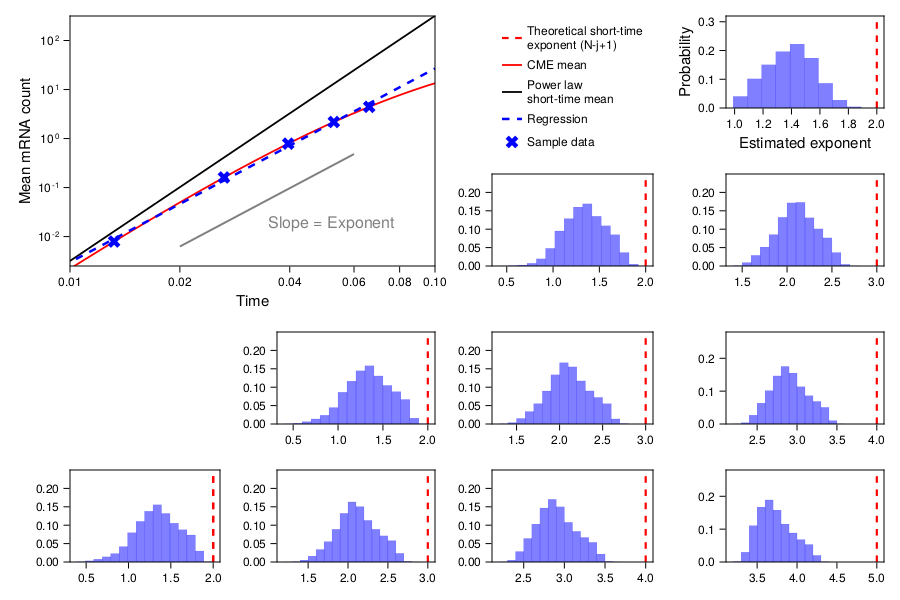

In [43]:
#Plot Fig. 4

fig_4 = Figure(resolution = (900, 600))

#histograms of estimated exponent (grid)
for i in 1:1:10

    if i==1
        ax = Axis(fig_4[hist_row_idx[i], hist_col_idx[i]], xlabel="Estimated exponent", ylabel="Probability",
          xlabelsize=15, xticklabelsize=12, ylabelsize=15, yticklabelsize=12, xticks = ([1.0,1.2,1.4,1.6,1.8,2.0]))
    elseif i==3 || i==6 || i==10
        ax = Axis(fig_4[hist_row_idx[i], hist_col_idx[i]],
          xlabelsize=15, xticklabelsize=12, ylabelsize=15, yticklabelsize=12, xticks = ([0.5,1.0,1.5,2.0]))
    else
        ax = Axis(fig_4[hist_row_idx[i], hist_col_idx[i]],
          xlabelsize=15, xticklabelsize=12, ylabelsize=15, yticklabelsize=12)
    end

    hist!(ax, slope_vec_linreg[i], bins=bin_edges_linreg[i], normalization=:probability, color=bbblue, strokewidth = 0.25, strokecolor =bbblue)

    ll = lines!(ax, [true_exp[i], true_exp[i]], [0, y_lim_linreg[i]], color=:red, linewidth=2.2, linestyle=:dash)
    
    hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
    
    CairoMakie.ylims!(ax, 0, y_lim_linreg[i])
    
end
ll = lines!(ax, [true_exp[1], true_exp[1]], [0, y_lim_linreg[1]], color=:red, linewidth=2.2, linestyle=:dash)

#Example regression plot

ax = Axis(fig_4[1:2, 1:2], xlabel="Time", ylabel="Mean mRNA count", xscale=log10, yscale=log10,
          xlabelsize=15, xticklabelsize=12, ylabelsize=15, yticklabelsize=12, xticks=([10^-2,2*10^-2,4*10^-2,6*10^-2,8*10^-2,10^-1]))

#theoretical mean line
tml = lines!(t_save_lines, theory_line_vec, color=:black, linewidth=1.8)

#true mean line
mean_line = lines!(t_save_lines, cme_mean_t, color=:red, linewidth=1.8)

#regression line
reg_line = lines!(t_save_lines, reg_line_vec, color=bblue, linewidth=2.5, linestyle=:dash)

#sample data points
dp1 = CairoMakie.scatter!(t_save, mean_t, color=bblue, marker=:xcross, markersize=18)

#slope = exponent line
example_line = lines!(t_save_lines[20:60], example_line_vec[20:60], color=:grey, linewidth=2)

box = Box(fig_4[1:2, 1:2], color=(:white,0), strokecolor = (:white,0))
lbl = Label(fig_4[1:2, 1:2], "Slope = Exponent", color=:grey, padding = (20, 40, 35, 20), halign=:right, valign=:bottom)

CairoMakie.xlims!(10^-2, 10^-1)
CairoMakie.ylims!(10^(-2.6), 10^(2.5))

Legend(fig_4[1,3], [ll, mean_line, tml, reg_line, dp1], ["Theoretical short-time
exponent (N-j+1)", "CME mean", "Power law 
short-time mean", "Regression", "Sample data"],
    framevisible=false, halign=:right, valign=:top, labelsize=12)

hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

colsize!(fig_4.layout, 1, Fixed(150))

fig_4